In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from matplotlib import gridspec
import matplotlib
from tqdm import tqdm_notebook
from astropy.modeling.models import Gaussian1D
from astropy.modeling import fitting
from astropy.table import Table
from astropy import units
from scipy.signal import medfilt
from scipy.ndimage import percentile_filter
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks

sc = '#132338'
esc = '#1764ff'

from pylab import *
colormap='inferno'

cmap = cm.get_cmap(colormap, 256)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)
plot_colors = colors[np.array([ 50,  90, 135, 180, 205, 230],dtype=int)]

## Load in the transmission spectra

In [2]:
# path to where the data are stored
path = '/Users/belugawhale/Documents/GitHub/cos_flares/zenodo/'

spec_b = np.loadtxt(path+'au_mic_b_disequil_profile.dat', skiprows=2)
spec_c = np.loadtxt(path+'au_mic_c_disequil_profile.dat', skiprows=2)

equil_spec_b = np.loadtxt(path+'au_mic_b_equil_profile.dat', skiprows=2)
equil_spec_c = np.loadtxt(path+'au_mic_c_equil_profile.dat', skiprows=2)

## Load in the vertical T-P profiles

In [3]:
tab_b = Table.read(path+'au_mic_b_disequil_vert_profs.dat', format='ascii')
tab_c = Table.read(path+'au_mic_c_disequil_vert_profs.dat', format='ascii')

equil_tab_b = Table.read(path+'au_mic_b_equil_vert_profs.dat', format='ascii')
equil_tab_c = Table.read(path+'au_mic_c_equil_vert_profs.dat', format='ascii')

In [4]:
def plot_table(tab, ax, colors, label=False, linestyle='-'):
    global keys, labels
    for i, k in enumerate(keys):
        if label:
            ax.plot(tab[k], tab['press'], colors[i], lw=4, 
                    label=labels[i], linestyle=linestyle)
        else:
            ax.plot(tab[k], tab['press'], colors[i], lw=4, linestyle=linestyle)
    return

def plot_spectrum(equil, disequil, ax, label=False, alpha=0.3, ks=31, lw=3, 
                  ceq=esc, cdis=sc):
    
    equil_filt = medfilt(equil[:,1], ks)
    diseq_filt = medfilt(disequil[:,1], ks)
    
    norm_equil = np.nanmedian(equil_filt[:100])
    norm_diseq = np.nanmedian(diseq_filt[:100])
    
    
    if label:
        ax.plot((equil[:,0]*units.m).to(units.micron), 
                equil_filt/norm_equil, c=ceq, lw=lw,
                label='Equilibrium Profile', zorder=10)
        ax.plot((disequil[:,0]*units.m).to(units.micron), 
                diseq_filt/norm_diseq, c=cdis, lw=lw, 
                label='Disequilibrium Profile', zorder=10)
        
    else:
        ax.plot((equil[:,0]*units.m).to(units.micron), 
            equil_filt/norm_equil, c=ceq, lw=lw, zorder=10)
        ax.plot((disequil[:,0]*units.m).to(units.micron), 
                diseq_filt/norm_diseq, lw=lw, 
                c=cdis, zorder=10)
        
    if cdis=='#132338':
        ax.plot((disequil[:,0]*units.m).to(units.micron), 
                 disequil[:,1]/norm_diseq, c='#969594', alpha=0.65)
    else:
        ax.plot((disequil[:,0]*units.m).to(units.micron), 
                 disequil[:,1]/norm_diseq, c=cdis, alpha=0.65)
    ax.plot((equil[:,0]*units.m).to(units.micron), 
             equil[:,1]/norm_equil, c=ceq, alpha=0.4)
    
        
    return

def tp_profile(equil, disequil, ax, label=False, alpha=0.3, ks=31, lw=3):
    twin = ax.twiny()
    twin.loglog(equil['temp'], equil['press'],
                c=sc, label='Equilibrium', lw=lw, linestyle='--')
    twin.loglog(disequil['temp'], disequil['press'], c=sc, 
                label='Disequilibrium', lw=lw)
    twin.set_ylim(10e-7, 10e2)
    twin.set_xlim(3*10**2, 2*10**3)
    
    if label==True:
        twinlgnd = twin.legend(bbox_to_anchor=(0., 1.2, 0.8, .102), loc=3,
                               ncol=3, mode="expand", borderaxespad=0.,
                               fontsize=24)
        for handle in twinlgnd.legendHandles:
            handle.set_linewidth(6)
    twin.set_xlabel('Temperature [K]', fontsize=28)
        
    twin.set_xticks([300,400,600,1000,2000])
    twin.set_xticklabels([str(e) for e in [300,400,600,1000,2000]])

# New Mock Up

### Which species to plot

In [5]:
keys = np.array(['nh3', 'h2o', 'ch4', 'co2', 'co', 'c2h6'])
labels = np.array([r'NH$_3$', r'H$_2$O', r'CH$_4$', r'CO$_2$', 'CO', r'C$_2$H$_6$'])


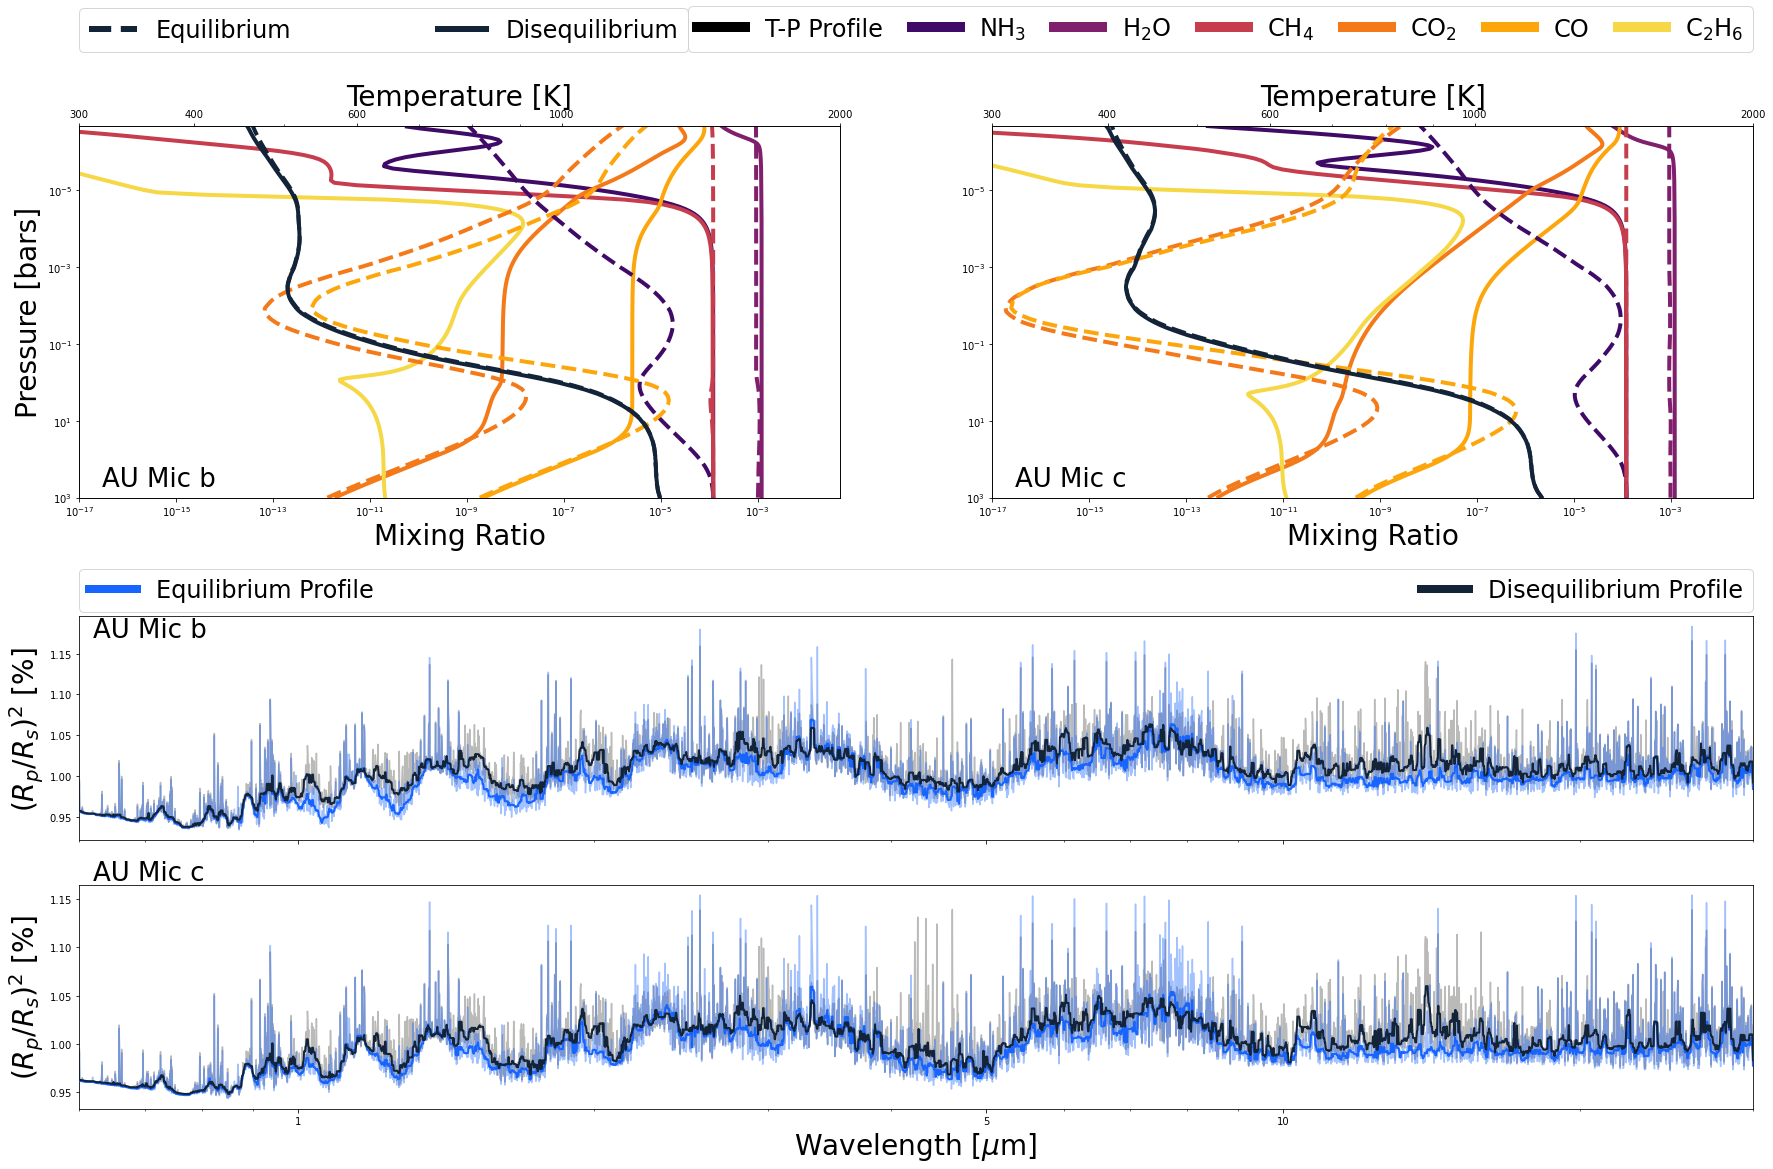

In [7]:
fig = plt.figure(figsize=(30,14))
gs_top = gridspec.GridSpec(3,2, top=1.1, height_ratios=[1.5,1,1])
gs_bottom = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs_top[0, 0])
ax3 = fig.add_subplot(gs_top[0, 1])
ax2 = fig.add_subplot(gs_bottom[1, :])
ax4 = fig.add_subplot(gs_bottom[2, :])


fig.set_facecolor('w')

sc = '#132338'
esc = '#1764ff'

ks=11

plot_spectrum(equil_spec_b, spec_b, ax2, label=True, ks=ks, lw=2)
plot_spectrum(equil_spec_c, spec_c, ax4, ks=ks, lw=2)


lgd = ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                 ncol=2, mode="expand", borderaxespad=0., fontsize=24)
for handle in lgd.legendHandles:
    handle.set_linewidth(8)

ax1.plot([1e4, 1e5], [1e4, 1e5], 'k', label='T-P Profile')
    
plot_table(tab_b, ax1, colors=plot_colors, label=True)
plot_table(tab_c, ax3, colors=plot_colors)

plot_table(equil_tab_b, ax1, colors=plot_colors, linestyle='--')
plot_table(equil_tab_c, ax3, colors=plot_colors, linestyle='--')

lgd = ax1.legend(bbox_to_anchor=(0.8, 1.2, 1.4, .102), loc=3,
                 ncol=7, mode="expand", borderaxespad=0., fontsize=24)
for handle in lgd.legendHandles:
    handle.set_linewidth(10)


tp_profile(equil_tab_b, tab_b, ax1, label=True, 
           lw=4)
tp_profile(equil_tab_c, tab_c, ax3, label=False,lw=4)

fs = 28
ax1.set_xlabel('Mixing Ratio', fontsize=fs)    
ax3.set_xlabel('Mixing Ratio', fontsize=fs)
ax4.set_xlabel('Wavelength [$\mu$m]', fontsize=fs)
ax1.set_ylabel('Pressure [bars]', fontsize=fs)
ax4.set_ylabel('($R_p/R_s)^2$ [%]', fontsize=fs)
ax2.set_ylabel('($R_p/R_s)^2$ [%]', fontsize=fs)

for i, ax in enumerate([ax2, ax4]):
    ax.set_xscale('log')
    ax.set_xlim(0.6,30)
    xticks = [1,5,10]
    ax.set_xticks(xticks)
    if i == 0:
        ax.set_xticklabels([])
    else:   
        ax.set_xticklabels(xticks)

for ax in [ax1, ax3]:
    ax.set_xlim(1e-17, 0.05)
    ax.set_ylim(1000, 2.2e-7)
    ax.set_xscale('log')
    ax.set_yscale('log')

ax1.text(s='AU Mic b', x=3e-17, y=5e2, fontsize=26)
ax3.text(s='AU Mic c', x=3e-17, y=5e2, fontsize=26)

ax2.text(s='AU Mic b', x=0.62, y=1.17, fontsize=26)
ax4.text(s='AU Mic c', x=0.62, y=1.17, fontsize=26);